In [80]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import datetime

## Preprocessing

- Only run model on data March 2024 and before (there is unit price and prescription data for this)
- Create y dependent variable (`sales_per_capita`) by `agg_prescriptions` * `unit_price` / `population`
- 

In [131]:
# Load the data
df = pd.read_csv('vital_bio_csv/aggregated_dataset.csv')
population_df = pd.read_csv('city_code_population_demographics.csv')

# Count distinct city_code from population_df
distinct_city_codes_count = population_df['city_code'].nunique()
print(f"Distinct city_code count from population_df: {distinct_city_codes_count}")


# Merge population data with sales data
df = df.merge(population_df, on='city_code', how='left')  # Adjust 'city' to match your column names
# Check which cities from population_df didn't match with the aggregated dataset
unmatched_cities = population_df[~population_df['city_code'].isin(df['city_code'])]
print("\nCities in population data that didn't match aggregated dataset:")
print(unmatched_cities[['city', 'city_code']])

# Show cities with missing population before dropping
missing_pop_cities = df[df['city_population'].isna()]['city_code'].unique()
print("Cities dropped due to missing population:")
print(missing_pop_cities)

# Drop rows where population is missing
df = df.dropna(subset=['city_population'])

# Print number of unique cities after dropping
print(f"\nNumber of unique cities after dropping: {df['city_code'].nunique()}")


# Create sales variable 
df['sales'] = df['agg_prescriptions'] * df['unit_price']

# Create per capita metrics
df['sales_per_capita'] = df['sales'] / df['city_population']
# df['prescriptions_per_capita'] = df['agg_prescriptions'] / df['population']

# Convert month_year to datetime
df['month_year'] = pd.to_datetime(df['month_year'])

# Filter for data up to March 2024
cutoff_date = pd.to_datetime('2024-03-01')
df = df[df['month_year'] <= cutoff_date]

print(len(df['city'].unique()))
print(df['city_code'])

# Prepare features - drop sales and any non-numeric columns
feature_cols = df.select_dtypes(include=['int64', 'float64']).columns # Drops the date column
feature_cols = feature_cols.drop(['sales', 'agg_prescriptions', 'unit_price','ID','latitude','longitude'])  # Drop population since we're using per capita
# Print features and their data types
print("\nFeatures being used in model:")
print("-" * 50)
for col in feature_cols:
    print(f"{col:<25} {df[col].dtype}")
print("-" * 50)

# Add population as a control variable
X = df[feature_cols.tolist()] 
y = df['sales']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Distinct city_code count from population_df: 70

Cities in population data that didn't match aggregated dataset:
       city city_code
4   AKSARAY    City05
17   BURDUR    City22
35  KARABÜK    City44
Cities dropped due to missing population:
['City07' 'City12']

Number of unique cities after dropping: 65
65
0      City01
1      City01
2      City01
3      City01
4      City01
        ...  
773    City82
774    City82
775    City82
776    City82
777    City82
Name: city_code, Length: 664, dtype: object

Features being used in model:
--------------------------------------------------
event_congress            float64
event_meeting             float64
F2F_visit                 float64
remote_visit              float64
Mass Mail Count           float64
Rep Triggered Email Count float64
province_population       float64
province_population_growth_rate_22_23 float64
province_population_density float64
province_males            float64
province_females          float64
province_foreign_popul

In [82]:
# Run GLM for each city to check linear relationships
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Create dictionary to store R2 scores for each city
city_r2_scores = {}

# For each city
for city in df['city'].unique():
    # Filter data for this city
    city_data = df[df['city'] == city]
    # print(city_data)
    # Skip if too few data points
    if len(city_data) < 30:
        continue
        
    # Prepare X and y for this city
    X_city = city_data[feature_cols]
    y_city = city_data['sales']
    
    # Split data into train and test sets for proper evaluation
    X_train_city, X_test_city, y_train_city, y_test_city = train_test_split(
        X_city, y_city, test_size=0.2, random_state=42
    )
    
    # Fit linear model on training data
    model = LinearRegression()
    model.fit(X_train_city, y_train_city)
    
    # Get R2 score on test data
    y_pred = model.predict(X_test_city)
    r2 = r2_score(y_test_city, y_pred)
    
    # Store R2 score
    city_r2_scores[city] = r2

# Convert to DataFrame and sort by R2 score
r2_df = pd.DataFrame.from_dict(city_r2_scores, orient='index', columns=['R2'])
r2_df = r2_df.sort_values('R2', ascending=False)

# Print top 10 cities with best linear relationships
print("\nTop 10 cities with strongest linear relationships:")
print("-" * 50)
print(r2_df.head(10))

# Print bottom 10 cities
print("\nBottom 10 cities with weakest linear relationships:")
print("-" * 50)
print(r2_df.tail(10))

# Calculate summary statistics
print("\nSummary of R2 scores across all cities:")
print("-" * 50)
print(r2_df['R2'].describe())



Top 10 cities with strongest linear relationships:
--------------------------------------------------
Empty DataFrame
Columns: [R2]
Index: []

Bottom 10 cities with weakest linear relationships:
--------------------------------------------------
Empty DataFrame
Columns: [R2]
Index: []

Summary of R2 scores across all cities:
--------------------------------------------------
count       0
unique      0
top       NaN
freq      NaN
Name: R2, dtype: object


## Visualizations

In [83]:
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from folium import plugins

# Get cities by per capita sales and identify top 10
top_cities = df.groupby(['city', 'latitude', 'longitude'])['sales_per_capita'].mean().reset_index()
top_cities = top_cities.sort_values('sales_per_capita', ascending=False)
top_10_cities = set(top_cities.head(10)['city'].values)
print(top_cities.head())

# Scale up the values by multiplying by 1000 to show in thousands
top_cities['sales_per_capita'] = top_cities['sales_per_capita'] * 1000

# Create a base map centered on Turkey
m = folium.Map(location=[39.0, 35.0], zoom_start=6)

# Add circle markers for each city using actual coordinates
for idx, row in top_cities.iterrows():
    # Only create marker if lat/lon exists
    if pd.notna(row['latitude']) and pd.notna(row['longitude']):
        # Use blue for cities in top 10 set, red for others
        color = 'blue' if row['city'] in top_10_cities else 'red'
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=row['sales_per_capita']/10,  # Changes the radius of the circles
            popup=f"{row['city']}<br>Sales per capita: {row['sales_per_capita']:,.0f}",
            color=color,
            fill=True,
            fill_color=color
        ).add_to(m)

# Add a title
title_html = '''
             <h3 align="center" style="font-size:16px">
             <b>Per Capita Sales by City (in Thousands)</b>
             <br>
             <span style="font-size:12px">(Top 10 cities shown in blue)</span>
             </h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))

# Display the map
m

         city  latitude  longitude  sales_per_capita
18     EDİRNE   41.6771    26.5558          0.445287
9   BALIKESİR   39.6484    27.8826          0.384750
31  KIRIKKALE   39.8468    33.5153          0.325900
60  ÇANAKKALE   40.1456    26.4064          0.269098
59  ZONGULDAK   41.4564    31.7987          0.235008


### Export to JSON

In [84]:
# Create a dictionary with city data
city_data = []
for idx, row in top_cities.iterrows():
    if pd.notna(row['latitude']) and pd.notna(row['longitude']):
        city_data.append({
            'city': row['city'],
            'sales_per_capita': round(float(row['sales_per_capita'])),  # Round to nearest whole number
            # 'population': round(float(row['population'])/100000)*100000,  # Round to nearest 100k
            'latitude': float(row['latitude']),
            'longitude': float(row['longitude'])
        })

# Export to JSON file
import json
with open('city_sales_data.json', 'w', encoding='utf-8') as f:
    json.dump(city_data, f, indent=4, ensure_ascii=False)

print("Data exported to city_sales_data.json")


Data exported to city_sales_data.json


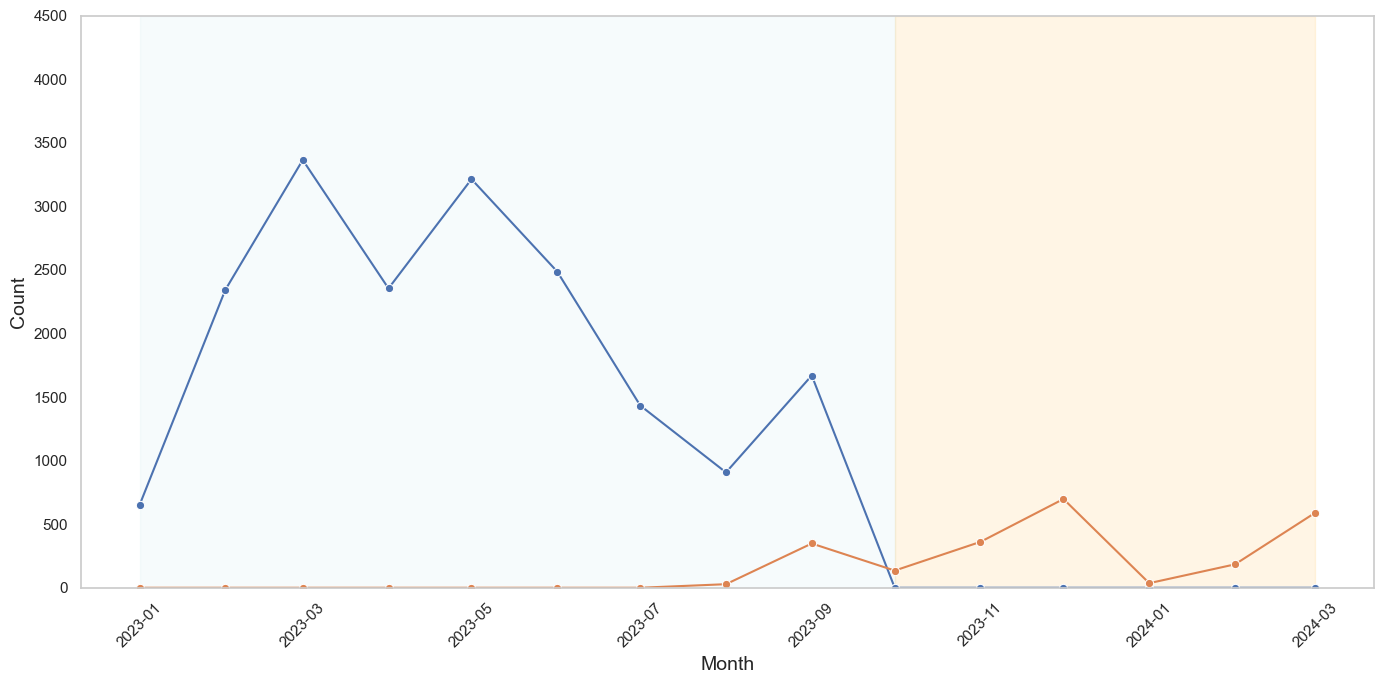

In [129]:
# ... existing imports ...
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'month_year' is in datetime format
df['month_year'] = pd.to_datetime(df['month_year'])

# Group by month and sum the values for F2F_visit and Rep Triggered Email Count
monthly_data = df.groupby(df['month_year'].dt.to_period('M')).agg({
    'F2F_visit': 'sum',
    'Rep Triggered Email Count': 'sum',
    'Mass Mail Count': 'sum',
    'event_meeting': 'sum',
    'event_congress': 'sum',
    'remote_visit': 'sum'
}).reset_index()

monthly_data.to_csv('monthly_events.csv')
# Convert 'month_year' back to datetime for plotting
monthly_data['month_year'] = monthly_data['month_year'].dt.to_timestamp()

palette = sns.color_palette()

# Create a line plot
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")
sns.despine() 
line1 = sns.lineplot(data=monthly_data, x='month_year', y='F2F_visit', marker='o', color=palette[0])
# sns.lineplot(data=monthly_data, x='month_year', y='remote_visit', label='Remote Visit', marker='o',color=palette[0])
# sns.lineplot(data=monthly_data, x='month_year', y='event_meeting', label='Meeting Event', marker='o',color=palette[0])
# sns.lineplot(data=monthly_data, x='month_year', y='event_congress', label='Congress Event', marker='o',color=palette[0])
line2 = sns.lineplot(data=monthly_data, x='month_year', y='Rep Triggered Email Count', marker='o', color=palette[1])
# sns.lineplot(data=monthly_data, x='month_year', y='Mass Mail Count', label='Mass Email', marker='o', color=palette[1])


# Add two vertical regions
plt.axvspan(pd.Timestamp("2023-01-01"), pd.Timestamp("2023-10-01"), color="lightblue", alpha=0.1)  # Region 1
plt.axvspan(pd.Timestamp("2023-10-01"), pd.Timestamp("2024-03-01"), color="orange", alpha=0.1)
# plt.axvline(x=pd.Timestamp("2023-10-01"), color='black', linestyle='--', linewidth=1.5)


# Add titles and labels
plt.title('', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
# plt.legend(title='Events', fontsize=20)
plt.grid()

# Set y limits
plt.ylim(0, 4500)

# plt.annotate('F2F Visit', 
#              xy=(monthly_data['month_year'].iloc[-1], monthly_data['F2F_visit'].iloc[-1]), 
#              xytext=(monthly_data['month_year'].iloc[-1], monthly_data['F2F_visit'].iloc[-1] + 10),  # Adjust y position for text
#              arrowprops=dict(facecolor=line1.lines[0].get_color(), shrink=0.05),
#              fontsize=12, ha='center')

# plt.annotate('Rep Triggered Email Count', 
#              xy=(monthly_data['month_year'].iloc[-1], monthly_data['Rep Triggered Email Count'].iloc[-1]), 
#              xytext=(monthly_data['month_year'].iloc[-1], monthly_data['Rep Triggered Email Count'].iloc[-1] + 10),  # Adjust y position for text
            #  arrowprops=dict(facecolor=line2.lines[0].get_color(), shrink=0.05),
            #  fontsize=12, ha='center')



# Show the plot
plt.tight_layout()
plt.show()



### Scatterplots

   city_code  city_population      sales
0     City01        2270298.0  3963179.0
1     City02         415273.0    93667.0
2     City03         458364.0   190239.0
3     City04         309721.0    35572.0
4     City06         248218.0   143115.0
..       ...              ...        ...
60    City78         287144.0   244178.0
61    City79        1127612.0   569364.0
62    City80         220802.0   120927.0
63    City81         276470.0    13630.0
64    City82         372627.0  1138414.0

[65 rows x 3 columns]


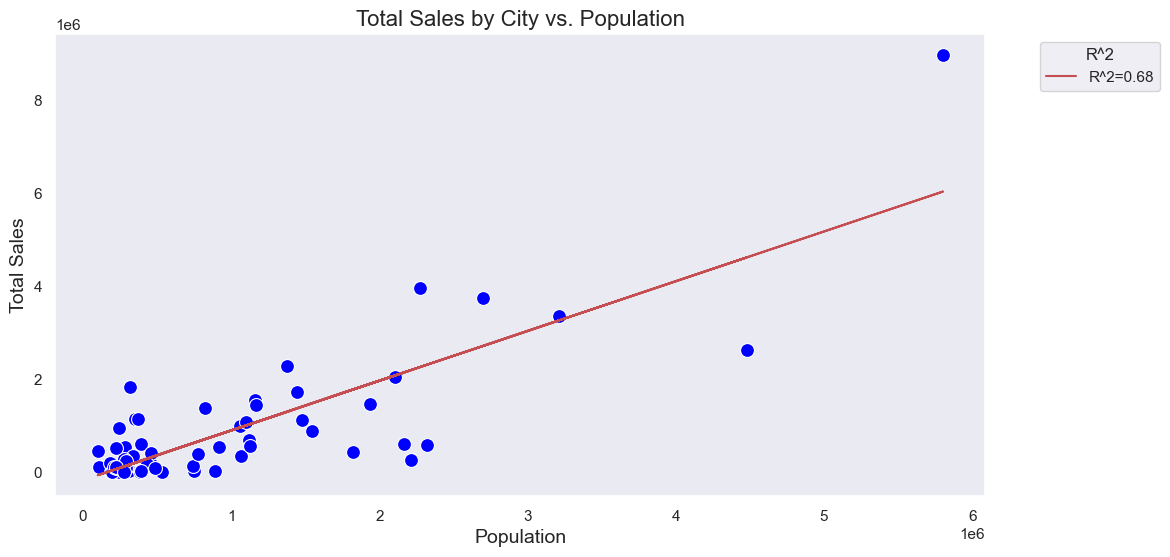

In [86]:
# ... existing imports ...
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Calculate total sales by city and population
total_sales_by_city = df.groupby(['city_code', 'city_population'])['sales'].sum().reset_index()
print(total_sales_by_city)

# Create a scatter plot with all cities the same color
plt.figure(figsize=(12, 6))
sns.scatterplot(data=total_sales_by_city, x='city_population', y='sales', color='blue', s=100)

# Calculate and plot the line of best fit
slope, intercept, r_value, p_value, std_err = linregress(total_sales_by_city['city_population'], total_sales_by_city['sales'])
line = f"R^2={r_value**2:.2f}"
plt.plot(total_sales_by_city['city_population'], intercept + slope*total_sales_by_city['city_population'], 'r', label=line)

# Add titles, labels, and legend with only R^2 value
plt.title('Total Sales by City vs. Population', fontsize=16)
plt.xlabel('Population', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.legend(title='R^2', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

# Show the plot
plt.show()

   city_code  population      sales
0     City01   2263373.0  3963179.0
1     City02    632148.0    93667.0
2     City03    744179.0   190239.0
3     City04    524644.0    35572.0
4     City06    335331.0   143115.0
..       ...         ...        ...
60    City78    373183.0   244178.0
61    City79   1141015.0   569364.0
62    City80    291001.0   120927.0
63    City81    418500.0    13630.0
64    City82    589684.0  1138414.0

[65 rows x 3 columns]
   city_code  population      sales  sales_per_capita
0     City01   2263373.0  3963179.0          1.751006
1     City02    632148.0    93667.0          0.148173
2     City03    744179.0   190239.0          0.255636
3     City04    524644.0    35572.0          0.067802
4     City06    335331.0   143115.0          0.426787
..       ...         ...        ...               ...
60    City78    373183.0   244178.0          0.654312
61    City79   1141015.0   569364.0          0.498998
62    City80    291001.0   120927.0          0.415555
63   

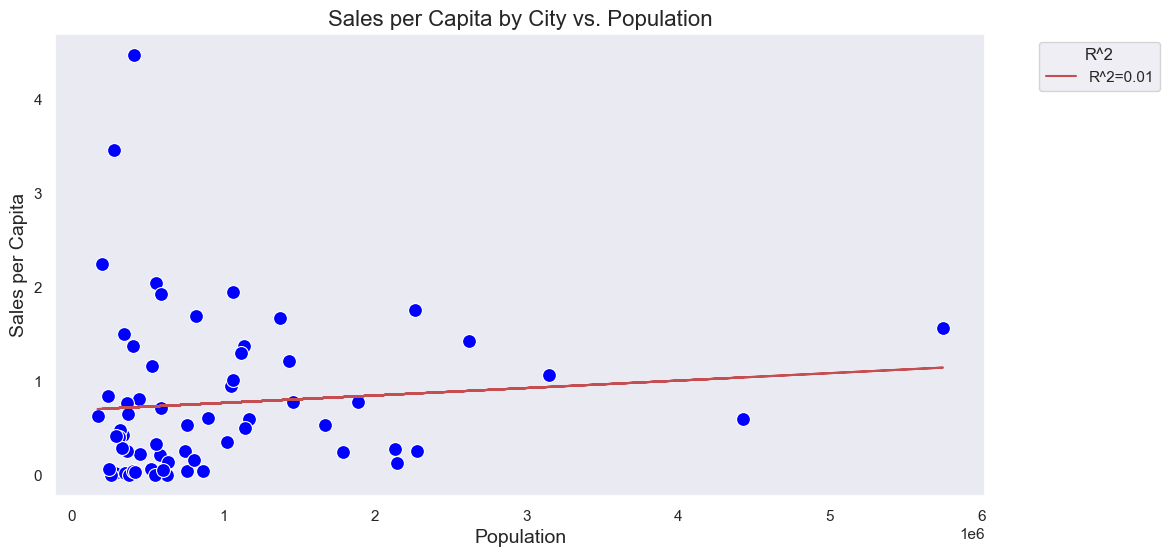

In [77]:
# ... existing imports ...
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Calculate total sales per capita by city and population
total_sales_by_city = df.groupby(['city_code', 'population'])['sales'].sum().reset_index()
print(total_sales_by_city)


total_sales_by_city['sales_per_capita'] = total_sales_by_city['sales']/total_sales_by_city['population']
print(total_sales_by_city)

# Create a scatter plot with all cities the same color
plt.figure(figsize=(12, 6))
sns.scatterplot(data=total_sales_by_city, x='population', y='sales_per_capita', color='blue', s=100)

# Calculate and plot the line of best fit
slope, intercept, r_value, p_value, std_err = linregress(total_sales_by_city['population'], total_sales_by_city['sales_per_capita'])
line = f"R^2={r_value**2:.2f}"
plt.plot(total_sales_by_city['population'], intercept + slope*total_sales_by_city['population'], 'r', label=line)

# Add titles, labels, and legend with only R^2 value
plt.title('Sales per Capita by City vs. Population', fontsize=16)
plt.xlabel('Population', fontsize=14)
plt.ylabel('Sales per Capita', fontsize=14)
plt.legend(title='R^2', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

# Show the plot
plt.show()

## Model Training
- Some basic GridSearch
- Optimizing for `neg_mean_squared_error`

In [29]:
# Perform hyperparameter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize base model
base_model = XGBRegressor(random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get best parameters and model
print("Best parameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

# Use the best model for predictions
model = grid_search.best_estimator_
y_pred = model.predict(X_test)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


/Users/liamkopp/dev/MMAI-Bae/.conda/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}
Best score: 283397111.67169726


## Model Measurement

In [30]:
# Calculate regression metrics
mse = int(mean_squared_error(y_test, y_pred))
rmse = int(np.sqrt(mse))
r2 = r2_score(y_test, y_pred)
mae = int(mean_absolute_error(y_test, y_pred))
# Calculate adjusted R-squared
n = X_test.shape[0]  # number of observations
p = X_test.shape[1]  # number of predictors
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)


metrics_df = pd.DataFrame({
    'Metric': ['R-squared', 'Adjusted R-squared', 'Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error'],
    'Value': [f'{r2:.3f}', f'{adj_r2:.3f}', mse, rmse, mae]
})
print("REGRESSION METRICS:\n===========================================")
print(metrics_df.to_string(index=False))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:\n===========================================")
print(feature_importance.head(10))

REGRESSION METRICS:
                 Metric      Value
              R-squared      0.932
     Adjusted R-squared      0.928
     Mean Squared Error 2007347735
Root Mean Squared Error      44803
    Mean Absolute Error      11632

Top 10 Most Important Features:
                     feature  importance
6                 population    0.627391
7           sales_per_capita    0.326157
5  Rep Triggered Email Count    0.030079
3               remote_visit    0.004589
1              event_meeting    0.003696
0             event_congress    0.003240
2                  F2F_visit    0.003143
4            Mass Mail Count    0.001705
